# Generate input files for MOM6
Required components
* Horizontal grid
    + determined externally using FRE-NCtools, loaded here to provide geometry
* Vertical grid
    + either calculated here, or externally
* Sponge region
    + calculated here
* Intial conditions for tracers
    + T, S and biogeochemical tracers, calculated here
* Wind and buoyancy forcing
    + calculated here
* Topography
    + calculated here
* Inital velocity perturbation
    + used to nudge the model
    + calculated here


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import initialization_functions as infs

In [3]:
# Directory into which to save files
rootdir = '/work/gam/MOM6/inputs/'
config = 'channel'
simulation = '4th-deg'

In [4]:
# Load the grid
gridpath = '../../ocean_geometry.nc'
hgrid = xr.open_dataset(gridpath)
hgrid_ones = xr.ones_like(hgrid['geolon'])

In [5]:
X,Y = infs.calc_XYmeters(hgrid,center_x = True)

In [6]:
# Vertical grid
nk = 50
max_depth = 4000
min_depth = 0
thkcello_topcell = 1
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,thkcello_topcell=thkcello_topcell,method=method)
# Save
#vgrid.to_netcdf(rootdir+config+'/'+simulation+'_vgrid'+'.nc')
#vgrid.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_vgrid'+'.nc')

In [7]:
vgrid

<xarray.Dataset>
Dimensions:  (NK: 50, NKp1: 51)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 4.347 10.27 ... 3.668e+03 3.832e+03 4e+03
  * NK       (NK) float64 0.5 2.674 7.309 14.58 ... 3.588e+03 3.75e+03 3.916e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 4.347 10.27 ... 3.668e+03 3.832e+03 4e+03
    zt       (NK) float64 0.5 2.674 7.309 14.58 ... 3.588e+03 3.75e+03 3.916e+03
    dz       (NK) float64 1.0 3.347 5.923 8.63 11.43 ... 156.4 160.1 163.9 167.7

In [8]:
# Temperature and salinity initial conditions
Tn = 10
Ts = 0
Sn = 35
Ss = 35

TS = xr.Dataset()
TS['SST'] = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Tn, val_at_mincoord = Ts)
TS['SSS'] = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Sn, val_at_mincoord = Ss)

# Extend temperature and salinity in the vertical
TS['T'] = infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', val_at_maxcoord = TS['SST'], efolding = 800)
TS['S'] = infs.calc_distribution(coordinate=-vgrid.zt, function = 'linear', val_at_maxcoord = TS['SSS'], val_at_mincoord = TS['SSS'])

TS = TS.transpose('NK','lath','lonh')
#TS.to_netcdf(rootdir+config+'/'+simulation+'_TS'+'.nc')
#TS.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_TS'+'.nc')

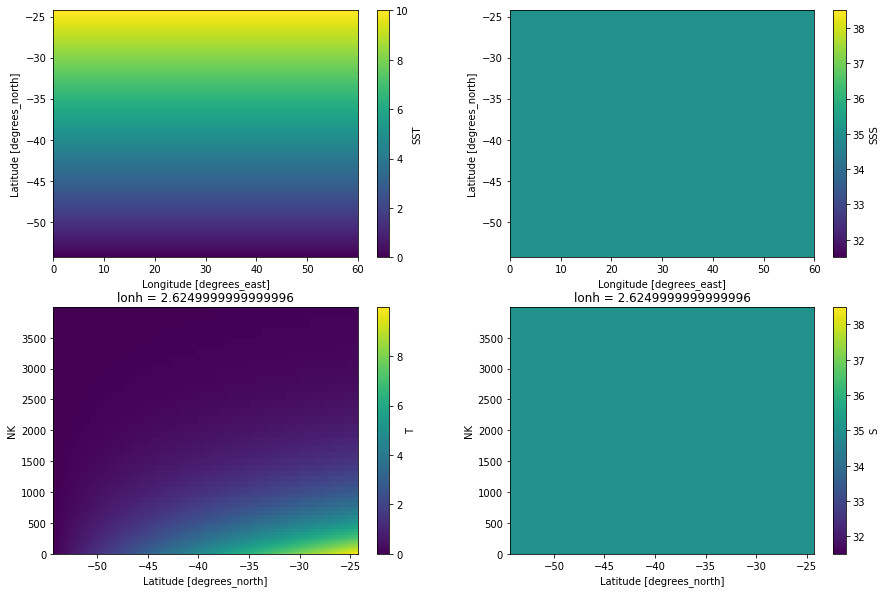

In [9]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
TS.SST.plot()

plt.subplot(2,2,2)
TS.SSS.plot()

plt.subplot(2,2,3)
TS.T.isel(lonh = 10).plot()

plt.subplot(2,2,4)
TS.S.isel(lonh = 10).plot()

In [10]:
# Sponge region
sponge_width = [100E3,50E3]
idampval=[1/(7*86400),1*0/(7*86400)]

sponge = xr.Dataset()
sponge['idamp'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)
sponge['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

# Add temperature and salinity profile to sponge region
sponge['T'] = TS['T']
sponge['S'] = TS['S']

sponge = sponge.transpose('NKp1','NK','lath','lonh')
#sponge.to_netcdf(rootdir+config+'/'+simulation+'_sponge'+'.nc')
#sponge.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_sponge'+'.nc')

In [11]:
sponge

<xarray.Dataset>
Dimensions:  (NK: 50, NKp1: 51, lath: 160, lonh: 240)
Coordinates:
  * lath     (lath) float64 -54.27 -54.13 -53.98 -53.83 ... -24.81 -24.58 -24.36
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.37 59.62 59.87
  * NKp1     (NKp1) float64 0.0 1.0 4.347 10.27 ... 3.668e+03 3.832e+03 4e+03
  * NK       (NK) float64 0.5 2.674 7.309 14.58 ... 3.588e+03 3.75e+03 3.916e+03
Data variables:
    idamp    (lath, lonh) float64 0.0 0.0 0.0 ... 1.653e-06 1.653e-06 1.653e-06
    eta      (NKp1, lath, lonh) float64 -0.0 -0.0 -0.0 ... -4e+03 -4e+03 -4e+03
    T        (NK, lath, lonh) float64 0.0 0.0 0.0 ... 0.07483 0.07483 0.07483
    S        (NK, lath, lonh) float64 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0

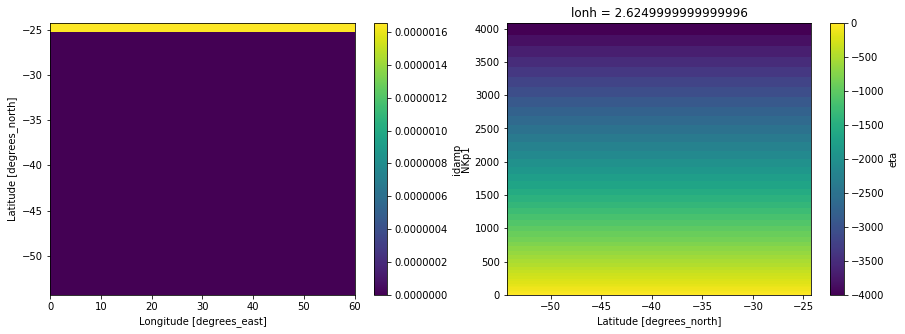

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sponge.idamp.plot()

plt.subplot(1,2,2)
sponge.eta.isel(lonh = 10).plot()

In [13]:
# Wind forcing
taux_east = 0.15
taux_west = 0.05
Y0 = 500*1E3 # Boundary between ACC/ASF
Yb = 1200*1E3 # Meridional position of bump
Ys = 300*1E3 # Location of continental slope
Ws = 75*1E3 # Half-width of continental slope
Lc = 100*1E3 # Width of shelf cooling


wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_squared',
                                 sponge_width_max = sponge_width[0],
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west)
wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
wind = wind.transpose('lath','lonh')
#wind.to_netcdf(rootdir+config+'/'+simulation+'_wind'+'.nc')
#wind.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_wind'+'.nc')

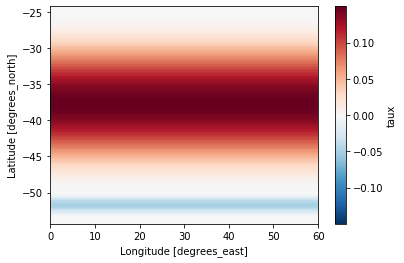

In [14]:
wind.taux.plot()

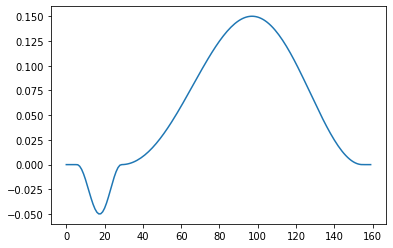

In [16]:
plt.plot(wind.taux.isel(lonh=1))

In [15]:
# Buoyancy Forcing
Buo_east = 10. # W/m^2
Buo_west = 5.
Y0 = 500*1E3 # Boundary between ACC/ASF
Yb = 1200*1E3 # Meridional position of bump
Ys = 300*1E3 # Location of continental slope
Ws = 75*1E3 # Half-width of continental slope
Lc = 100*1E3 # Width of shelf cooling

buoyancy = xr.Dataset()
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid',
                                 sponge_width_max = sponge_width[0],
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west)

buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
buoyancy = buoyancy.transpose('lath','lonh')
#buoyancy.to_netcdf(rootdir+config+'/'+simulation+'_buoyancy'+'.nc')
#buoyancy.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_buoyancy'+'.nc')

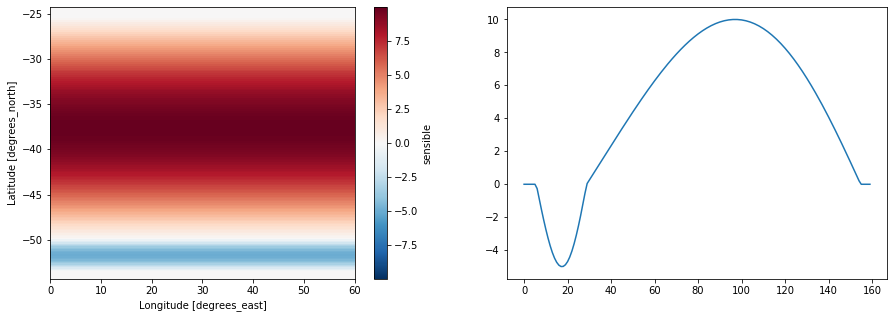

In [16]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
buoyancy.sensible.plot()

plt.subplot(1,2,2)
plt.plot(buoyancy.sensible.isel(lonh=1))

In [18]:
# MESO Buoyancy Forcing
Buo_east = 10. # W/m^2
Buo_west = 5.
Y0 = 500*1E3 # Boundary between ACC/ASF
Yb = 1200*1E3 # Meridional position of bump
Ys = 300*1E3 # Location of continental slope
Ws = 75*1E3 # Half-width of continental slope
Lc = 100*1E3 # Width of shelf cooling

Meso_buoyancy = xr.Dataset()
# Non short-wave heat flux
Meso_buoyancy['Heat'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
# Net precipitation - evaporation
Meso_buoyancy['PmE'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
# Short wave heat flux
Meso_buoyancy['NET_SOL'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
Meso_buoyancy = Meso_buoyancy.transpose('lath','lonh')
#buoyancy.to_netcdf(rootdir+config+'/'+simulation+'_buoyancy'+'.nc')
Meso_buoyancy.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_Meso_buoyancy'+'.nc')

In [19]:
Meso_buoyancy

<xarray.Dataset>
Dimensions:  (lath: 160, lonh: 240)
Coordinates:
  * lath     (lath) float64 -54.27 -54.13 -53.98 -53.83 ... -24.81 -24.58 -24.36
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.37 59.62 59.87
Data variables:
    Heat     (lath, lonh) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PmE      (lath, lonh) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NET_SOL  (lath, lonh) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [13]:
# Meso Surface Restoration
Tn = 10
Ts = 0
Sn = 35
Ss = 35

Meso_TS = xr.Dataset()
Meso_TS['SST'] = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Tn, val_at_mincoord = Ts)
Meso_TS['SAL'] = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Sn, val_at_mincoord = Ss)

Meso_TS = Meso_TS.transpose('lath','lonh')
#TS.to_netcdf(rootdir+config+'/'+simulation+'_TS'+'.nc')
Meso_TS.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_Meso_TS'+'.nc')

In [22]:
Meso_TS

<xarray.Dataset>
Dimensions:  (lath: 160, lonh: 240)
Coordinates:
  * lath     (lath) float64 -54.27 -54.13 -53.98 -53.83 ... -24.81 -24.58 -24.36
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.37 59.62 59.87
Data variables:
    TEMP     (lath, lonh) float64 0.0 0.0 0.0 0.0 0.0 ... 10.0 10.0 10.0 10.0
    SALT     (lath, lonh) float64 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0 35.0

In [23]:
# Intial velocity nudge
center = 0
width = 2E5

velocity = xr.Dataset()
u = infs.calc_distribution(coordinate=X*xr.ones_like(vgrid['zt']), function = 'gaussian', center = center, width = width)
velocity['u'] = infs.make_zeroinsponge(u,Y,sponge_width_max = sponge_width[0])
velocity['v'] = infs.calc_distribution(coordinate=X, function = 'uniform', uniform_value = 0.0)

# Save
velocity = velocity.transpose('NK','lath','lonh')
#velocity.to_netcdf(rootdir+config+'/'+simulation+'_velocity'+'.nc')
velocity.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_velocity'+'.nc')

In [24]:
def create_shelf(H, Hs, Y1, Ys, Ws):
    # H = max depth, Hs = shelf depth, Y1 = lat, Ys = shelf latitude, Ws = shelf width
    depth_shelf = 0.5*(H - Hs)*(1 - np.tanh((Y1 - Ys)/Ws))
    
    return depth_shelf

def create_2D_guassian_ridge(Hs, X1, Xs, Y1, Ys, Wx, Wy, theta):
    # Hs = ridge height, X1 = lon, Y1 = lat, Xs, Ys = shelf lan and lat, Wx, Wy = ridge length and width
    # ridge rotation
    
    a = np.cos(theta)**2/(2*Wx**2) + np.sin(theta)**2/(2*Wy**2);
    b = -np.sin(2*theta)/(4*Wx**2) + np.sin(2*theta)/(4*Wy**2);
    c = np.sin(theta)**2/(2*Wx**2) + np.cos(theta)**2/(2*Wy**2);

    Z = Hs*np.exp( - (a*(X1-Xs)**2 + 2*b*(X1-Xs)*(Y1-Ys) + c*(Y1-Ys)**2));
    
    return Z

def create_rectangular_bump(Hs, X1, Xs, Y1, Ys, Wx, Wy, dx, dy):
    # Hs = max depth X1 = lon, Y1 = lat, Xs, Ys = bump lan and lat, Wx, Wy = bump length and width
    # dx, dy = controls the rate of bump heigh decay
    x = (X1 - Xs)/Wx
    y = (Y1 - Ys)/Wy
    z = np.exp(-dx/(1 - x**2) - dy/(1 - y**2))
    
    condition = (np.abs(x) >= 1.) | (np.abs(y) >= 1.)
    z = z.where(~condition,0)
    
    z = z*Hs/np.max(z)
    
    return z

In [25]:
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, Ws)
#min_shelf_depth, shelf_lat, shelf_width = (500., -48., 2.0)
d_shelf = create_shelf(max_depth, min_shelf_depth, Y, shelf_lat, shelf_width)

ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., -1000000., 2000000., 500000., 5000000.)
#ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., 20., -35., 5.0, 50.)
theta = -30.*np.pi/180
d_ridge = create_2D_guassian_ridge(ridge_depth, X, ridge_lon, Y, ridge_lat, ridge_width_x, ridge_width_y, theta)

bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., -1000000., 2000000., 1000000.0, 1000000.)
#bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., 20., -40., 20.0, 15.)
bump_decay_x, bump_decay_y = (1., 1.)
d_bump = create_rectangular_bump(bump_depth, X, bump_lon, Y, bump_lat, bump_width_x, bump_width_y, 
                                 bump_decay_x, bump_decay_y)

#height = np.maximum(d_shelf, d_ridge*d_bump) 
height = np.maximum(d_shelf, d_bump*3000.) 

topography = xr.Dataset()
topography['depth'] = -1*(-max_depth + height)

# Save
topography.transpose('lath','lonh')
#topography.to_netcdf(rootdir+config+'/'+simulation+'_topography'+'.nc')
topography.to_netcdf('../../MOM6_PEM_INPUT/'+simulation+'_topography'+'.nc')

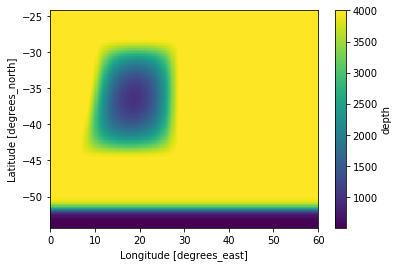

In [27]:
topography.depth.plot()